### Imports

In [312]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

### Load data

In [315]:
path = '/Users/Glebazzz/Jupiter/Taxi/02 Data/Prepared data'
df = pd.read_csv(os.path.join(path, 'final_clustered_data.csv'))

### Save original country for export

In [317]:
df['country_original'] = df['country']

### Drop useless columns

In [321]:
df = df.drop(columns=[
    'device_os_version', 'Unnamed: 0','real_destination_lat','real_destination_lng','user_id','order_id',
    'price_review_status','price_review_reason','has_price_review','log_distance.1','log_price_per_km.1',
    'is_night.1','ride_price_norm.1','failed_attempts.1','country.1','has_failed_attempt.1',
    'failed_before_success.1','log_price.1','cluster_behavior','payment_success','is_successful_payment'
], errors='ignore')

### Drop duplicate columns

In [324]:
df = df.loc[:, ~df.columns.duplicated()]

### Encode categorical columns

In [327]:
df['device_name'] = df['device_name'].map(df['device_name'].value_counts())
df['city_id'] = df['city_id'].map(df['city_id'].value_counts())
df = pd.get_dummies(df, columns=['country'], drop_first=True)

### Convert target column

In [330]:
df['payment_status'] = df['payment_status'].map({'fail': 0, 'success': 1})

### Define features and target

In [333]:
# Define features and target
X = df.drop(columns=['payment_status', 'name', 'card_bin', 'country_original'], errors='ignore')
y = df['payment_status']

# Remove non-numeric columns BEFORE splitting
X = X.select_dtypes(exclude='object')  
feature_names = X.columns  # Save after removing non-numeric cols

### Save original country before scaling

In [336]:
country_test = df.loc[:, ['country_original']].copy()

### Split

In [341]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
country_test = country_test.loc[X_test.index]

### Scale numeric features

In [344]:
# Drop object-type columns
X_train = X_train.select_dtypes(exclude=['object'])
X_test = X_test.select_dtypes(exclude=['object'])

# Then scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


### Train model

In [347]:
model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
model.fit(X_train_scaled, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

### Predict and evaluate

In [350]:
y_pred = model.predict(X_test_scaled)
print(classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.99      0.88      0.93      9973
           1       0.96      1.00      0.98     31825

    accuracy                           0.97     41798
   macro avg       0.98      0.94      0.96     41798
weighted avg       0.97      0.97      0.97     41798

ROC AUC Score: 0.93942628600757


### Feature Importance 

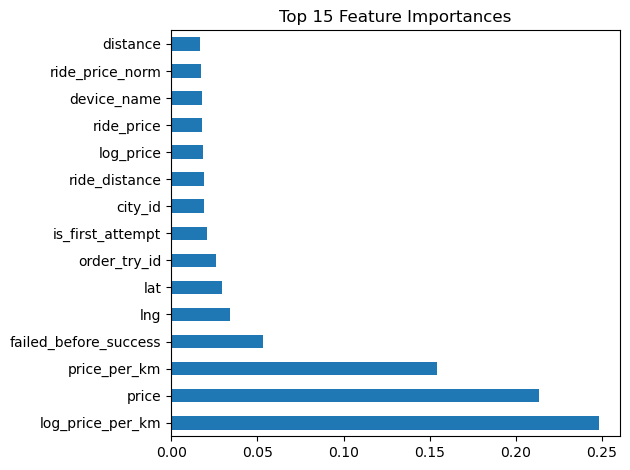

In [353]:
# Confirm lengths match before plotting
assert len(model.feature_importances_) == len(feature_names), \
    f"Mismatch: {len(model.feature_importances_)} importances vs {len(feature_names)} feature names"

# Plot top 15 important features
importances = pd.Series(model.feature_importances_, index=feature_names)
importances.nlargest(15).plot(kind='barh')
plt.title("Top 15 Feature Importances")
plt.tight_layout()
plt.show()

### 🔍 Interpretation

- The model demonstrates **high accuracy and recall**, especially for identifying fraudulent transactions.
- **Recall of 1.00 for fraud** (Class 1) means nearly all fraud cases are detected.
- Some **false positives** remain (lower recall for Class 0), which could impact user experience for legitimate users.
- Overall, the model is suitable for **risk-based interventions** and **real-time fraud scoring**.

---

## 🔝 Feature Importance Analysis

### Top 15 Features Contributing to Fraud Prediction

1. `log_price_per_km`
2. `price`
3. `price_per_km`
4. `failed_before_success`
5. `lng`
6. `lat`
7. `order_try_id`
8. `is_first_attempt`
9. `city_id`
10. `ride_distance`
11. `log_price`
12. `ride_price`
13. `device_name`
14. `ride_price_norm`
15. `distance`

### 🧠 Insights

- **Price-based features** (log/absolute/per km) are the most influential — suggesting price manipulation or edge-case pricing behavior is common in fraud.
- **Behavioral history**, especially failed attempts and retry patterns, is a strong fraud indicator.
- **Geolocation and device traits** help refine fraud segmentation for localized thresholds or device-level flagging.

---

## 🚀 Product Recommendations (PM Focus)

- Apply **soft blocks or verification prompts** for users with high `log_price_per_km` or `price_per_km`.
- Trigger **dynamic risk scoring** when a user has `failed_before_success > 0`.
- Consider **custom fraud thresholds** by region or device using `city_id`, `lat/lng`, and `device_name`.

### Export predictions

In [356]:
# STEP 14.5 — Predict probabilities
y_proba = model.predict_proba(X_test_scaled)[:, 1]

# STEP 15 — Export results properly
df_test = pd.DataFrame(X_test_scaled, columns=feature_names, index=X_test.index)
df_test['actual'] = y_test.values
df_test['predicted'] = y_pred
df_test['probability'] = y_proba
df_test['country'] = country_test['country_original'].values  # Flatten column from DataFrame


### Fill for Tableau

In [359]:
df_test['country'] = df_test['country'].fillna("Unknown")

In [361]:
# Save to CSV
df_test.to_csv(os.path.join(path, "fraud_predictions_results.csv"), index=False)